In [ ]:
!pip install --user dgl
!pip install --user --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install --user tensorboardX

# Training a Transformer modelled as a Graph Neural Network with [DGL library](www.dgl.org) on Mathematical Dataset

> You can contact me on twitter as [@mandubian](http://twitter.com/mandubian)

**This notebook demonstrates the concept of a [Transformer](https://arxiv.org/abs/1706.03762) implemented as a Graph Neural Network using the cool [DGL library](www.dgl.org) and trained on Mathematical Reasoning Dataset v1.0 (arithmeric/add_sub/easy).**

> All pictures in next paragraphs are just copies from this [DGL tutorial](https://docs.dgl.ai/en/latest/tutorials/models/4_old_wines/7_transformer.html) and [_All you need is attention_ paper](https://arxiv.org/abs/1706.03762) and I advise you to read both.

### Reminders on Transformer

A Transformer is an auto-regressive sequence-to-sequence model relying on 2 steps:

![Transformer Model](media/transformer_figure.png)

- A **multi-layer encoder** consisting in:

    * Multi-head and position-aware self-attention that extracts an encoding of the sequence weighted by a map of attention (or energy, importance, likelikhood as you prefer) between every element of the sequence contextually to all the other elements in the same sequence (complexity in $n^2$ , $n$ being the size of sequence) (_picture from DGL tutorial_). ![Forward/Backward Self-Attention](media/encoder_attention.png)
    * This builds an implicit relational data-storage containing all unique elements and their relations to all other elements encountered in the dataset.
    * From this raw storage, patterns with higher semantics are extracted by fully-connected feed-forward layers.
    * Both mechanisms together are designed to build a semantic relational embedding of any input sequence.
    * All layers are also followed by residual connections to avoid vanishing risks
    * FYI, multi-head is just the equivalent to increasing the volume of convolution filters in a CNN. You give it depth to let it discover different relations.


- A **multi-layer decoder** consisting in:
  
    * Multi-head and position-aware self-attention layer that extracts an encoding of the expected output sequence (_except the last element as we want to predict it from previous elements_) weighted by a map of attention between elements of the output sequence and every **previous** other elements in the same sequence. This backward-only dependency is aimed at ensuring the auto-regressive nature of the network and the fact that you predict the next element from its past, not from its future. (_picture from DGL tutorial_) ![Backward Self-Attention](media/decoder_attention.png)
    * Then, Multi-head and position-aware attention (_not self_) layer that encodes previously self-attention encoded output sequence (minus last element) weighted by a map of attention built on the above encoder's embedding of the input sequence (_Ouch I know it's not easy to put it in letters, look at Tranformer model above_). It allows to learn/represent the relations between every element in the output sequence with respect to elements in the input sequence. (_picture from DGL tutorial_) ![Backward Self-Attention](media/cross_language.png)
    * Then, Fully-connected feed-forward layer extracts patterns and finally predicts the last/next element of the sequence.
    * All layers are also followed by residual connections to avoid vanishing risks
    
> Transformer model has shown very high efficiency in discovering and storing semantic representation in sequences while being able to extract long-range relations (better than LSTM/RNN in all recent papers). Transformer is the cornerstone of models like BERT that beat all previous state of the art in recent language modeling.

### From Transformer to Graph Neural Network

In this small introduction to Transformer, I've been using the words `element` and `relation` quite often. When one thinks about elements having relations between each others, one immediately thinks about Graph.

Recently, beside Transformers, I've been studying the topic of Graph Neural Networks that allow to build deep learning models that are able to learn, classify, clusterize, transform, generate graphs.

Graph is certainly the most important data structure that you can find in all our recent systems. All social networks are based on that. Most database schema can be represented with graphs. Images can be seen are graphs. Result of Image segmentation or object detection can be seen as graphs. Any text can be modeled as a graph. Neural networks are themselves graphs, etc...

And actually when you look carefully at Transformer and specially the 3 images above (copied from DGL tutorial), you immediately discover a whole graph ![Full_Graph](media/full_graph.png)

- the **encoder self-attention** builds a full graph of the relations between every element and every others in the input sequence. Nodes of the graph are elements in the input sequence. Self-attention weights are the values on the edges between all nodes.
- the **decoder self-attention** builds a graph of the relations between every element and the previous ones in the output sequence. Nodes of the graph are elements in the output sequence. Self-attention weights are the values on the edges between all nodes.
- the **encoder/decoder attention** builds a graph of the relations between every element in the input sequence and every element in output sequence. Nodes of the graph are elements in the input/output sequence. Attention weights are the values on the edges between all nodes.


I won't spend more time explaining how graph neural networks work, it's another long topic and everything is very well explained in this very good [GDL tutorial](https://docs.dgl.ai/en/latest/tutorials/models/4_old_wines/7_transformer.html).

**Just keep in mind that Transformer can be seen as a special kind of Graph Neural Network that learns attention as the edge of the graph and finally reduces the whole graph in the prediction of the next element in the sequence.**

Graph Neural domain is not so young but it's getting more attraction lately due to recent papers, evolutions and GPU power increase. Nobody knows yet the true power of graph neural networks, multiple models have been studied till now. There are several mature libraries:

- [DGL library](www.dgl.org)
- [Pytorch Geometric](https://github.com/rusty1s/pytorch_geometric)
- [Deepmind GraphNets](https://github.com/deepmind/graph_nets).

I'm mainly using Pytorch lately so Geometric and DGL were good candidates. `Pytorch Geometric` provides a lot of already implemented models with good doc and seems to aim at optimizing those models with different modelization tricks (Graph Neural Network are not very light-weight apparently :D). _I think I'll give it a try soon._

For this Study, I've chosen `DGL` that provides a very idiomatic way to build graphs and very good documentation and tutorials and samples.

_I don't have any mind between both libraries as I haven't got enough experience in this domain. If anyone has, don't hesitate to tell me._

In the notebook, I train this DGL-Transformer on Mathematical Reasoning Dataset which is the main topic of this github repository and that was presented in this very cool paper:

> Analysing Mathematical Reasoning Abilities of Neural Models
>
> David Saxton, Edward Grefenstette, Felix Hill, Pushmeet Kohli
>
> (Submitted on 2 Apr 2019)
>
>http://arxiv.org/abs/1904.01557


Have fun and remember, you're not just a graph... or maybe you are ;)


In [8]:
import math
import numpy as np
import torch


#torch.multiprocessing.set_start_method("spawn")

from torch.utils import data
import torch.optim as optim

import math_dataset
from math_dataset import MathDatasetManager

from transformer.Models import Transformer
from math_dataset import (
    random_split_dataset,
    GraphCollate,
    MAX_ANSWER_SZ, MAX_QUESTION_SZ
)
import model_process
import utils
from tensorboard_utils import Tensorboard
from tensorboard_utils import tensorboard_event_accumulator

import checkpoints

from dgl_transformer.dgl_transformer import Transformer
from dgl_transformer.dataset.graph import GraphPool
import dgl_model_process

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook  

print("Torch Version", torch.__version__)

%load_ext autoreload
%autoreload 2

Torch Version 1.0.0.dev20190402
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#seed = 1
#torch.manual_seed(seed)
device = torch.device("cuda")
print("device", device)

device cuda


## Initializing Experiment

In [3]:
exp_name = "dgl_transformer_arithmetic_add_or_sub_easy"
unique_id = "2019-05-03_1000"

## Initializing Math Dataset Manager & Train/Val/Interpolate Datasets

Interpolate dataset is a general-purpose dataset provided besides basic datasets in math reasoning datasets. It contains more generic questions/answers to test the generalization capabilities of your network for a given problem after learning.

In [4]:
mdsmgr = MathDatasetManager(
  "/home/mandubian/datasets/mathematics_dataset/v1.0"
)

initialized MultiFilesMathDataset with categories ['algebra', 'numbers', 'polynomials', 'arithmetic', 'measurement', 'comparison', 'probability', 'calculus'] and types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']


In [5]:
ds = mdsmgr.build_dataset_from_module(
    'arithmetic', 'add_or_sub', 'train-easy'
)
print("train-easy dataset size", len(ds))

ds_interpolate = mdsmgr.build_dataset_from_module(
    'arithmetic', 'add_or_sub', 'interpolate'
)
print("interpolate dataset size", len(ds_interpolate))

train-easy dataset size 666666
interpolate dataset size 10000


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Build Model and Optimizer

In [6]:
model = utils.build_dgl_transformer()

In [7]:
optimizer = optim.Adam(model.parameters(), lr=6e-6, betas=(0.9, 0.995), eps=1e-9)


## Build Dataloaders

In [10]:
# Graph Collate allows to build graph batches for data_loader collation from raw math_dataset data
graph_collate = GraphCollate()

start creating graph pool...
successfully created graph pool, time: 4.079s


In [9]:
# here we split data in 80/10% for train/validation and use interpolate for test
train_ds, val_ds = math_dataset.random_split_dataset(ds, split_rate=0.8)

# we provide the function question_answer_to_position_batch_collate_fn that collates
# all questions/answers into transformer format enhanced with char positioning
train_loader = data.DataLoader(
    train_ds, batch_size=56, shuffle=True, num_workers=4,
    collate_fn=graph_collate(device), pin_memory=True)

val_loader = data.DataLoader(
    val_ds, batch_size=56, shuffle=False, num_workers=4,
    collate_fn=graph_collate(device))

interpolate_loader = data.DataLoader(
    ds_interpolate, batch_size=48, shuffle=False, num_workers=4,
    collate_fn=graph_collate(device))


## Training

In [10]:
tb = Tensorboard(exp_name, unique_name=unique_id)

Writing TensorBoard events locally to runs/dgl_transformer_arithmetic_add_or_sub_easy_2019-05-03_1000


In [11]:
model = model.to(device)


In [ ]:
dgl_model_process.train(
    exp_name, unique_id,
    model, 
    train_loader, val_loader, interpolate_loader,
    optimizer, device,
    graph_pool=None,
    epochs=20, tb=tb, log_interval=100,
    start_epoch=1,
)

## Training remarks

I trained this DGL-Graph transformer model for 6 epochs as every epochs takes about 1h15-1h30 on my 1080TI compared to classic Transformer that is about 20-30mn per epoch. I stopped it when it reached a quite flat gradient curve that is comparable to original Transformer training. But the training is clearly not yet over-fitting...

I've remarkerd that DGL model training runs much slower than original Transformer but it also consumes as much GPU as CPU. Building graphs apparently take lots of resources. In terms of GPU memory, for original Transformer, I could batch by 128 without any risk of going out of GPU memory. For DGL Transformer, I could go up to 56 elements for batches but with 64, I run out of memory as soon as I want to run validation. So DGL Transformer also consumes more GPU memory.

Let's also remark than in original Transformer training, I was using a train/validation dataset split of 90%/10% versus 80%/20% for DGL Transformer training. But it shouldn't change results so much due to the easy nature of arithmetic problems we are trying to learn in the current case.

Anyway, let's have a look at training curves.

## Training Results

### Extract data from Tensorboard logs

In [45]:
# Aggregating 3 runs that were done on same model to improve its performance
# and see best training accuracy on plots
original_transfo_train_ea_1 = tensorboard_event_accumulator(
    f"./runs/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_train/events.out.tfevents.1555939951.c77692173f6a"
)
original_transfo_train_ea_2 = tensorboard_event_accumulator(
    f"./runs/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_train/events.out.tfevents.1555967354.c77692173f6a"
)
original_transfo_train_ea_3 = tensorboard_event_accumulator(
    f"./runs/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_train/events.out.tfevents.1555969013.c77692173f6a"
)


original_transfo_valid_ea = tensorboard_event_accumulator(
    f"./runs/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_eval/events.out.tfevents.1555941107.c77692173f6a"
)

original_transfo_interpolate_ea = tensorboard_event_accumulator(
    f"./runs/math_ds_arithmetic_add_or_sub_easy_2019-04-22T13:32:24_interpolate/events.out.tfevents.1555941116.c77692173f6a"
)

original_transfo_train_accuracy_1 = original_transfo_train_ea_1.Scalars("epoch/accuracy")
original_transfo_train_accuracy_2 = original_transfo_train_ea_2.Scalars("epoch/accuracy")
original_transfo_train_accuracy_3 = original_transfo_train_ea_3.Scalars("epoch/accuracy")
#original_transfo_train_loss_per_char_1 = original_transfo_train_ea.Scalars("epoch/loss_per_char")

original_transfo_valid_accuracy = original_transfo_valid_ea.Scalars("epoch/accuracy")
#original_transfo_valid_loss_per_char = original_transfo_valid_ea.Scalars("epoch/loss_per_char")

original_transfo_interpolate_accuracy = original_transfo_interpolate_ea.Scalars("epoch/accuracy")
#original_transfo_interpolate_loss_per_char = original_transfo_interpolate_ea.Scalars("epoch/loss_per_char")


In [46]:
dgl_transfo_train_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_train/events.out.tfevents.1556872387.edbc806924f6"
)

dgl_transfo_valid_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_eval/events.out.tfevents.1556880346.edbc806924f6"
)

dgl_transfo_interpolate_ea = tensorboard_event_accumulator(
    f"./runs/{exp_name}_{unique_id}_interpolate/events.out.tfevents.1556880405.edbc806924f6"
)

dgl_transfo_train_accuracy = dgl_transfo_train_ea.Scalars("epoch/accuracy")
dgl_transfo_train_loss_per_char = dgl_transfo_train_ea.Scalars("epoch/loss_per_char")

dgl_transfo_valid_accuracy = dgl_transfo_valid_ea.Scalars("epoch/accuracy")
dgl_valid_loss_per_char = dgl_transfo_valid_ea.Scalars("epoch/loss_per_char")

dgl_transfo_interpolate_accuracy = dgl_transfo_interpolate_ea.Scalars("epoch/accuracy")
dgl_transfo_interpolate_loss_per_char = dgl_transfo_interpolate_ea.Scalars("epoch/loss_per_char")


### Training Logs

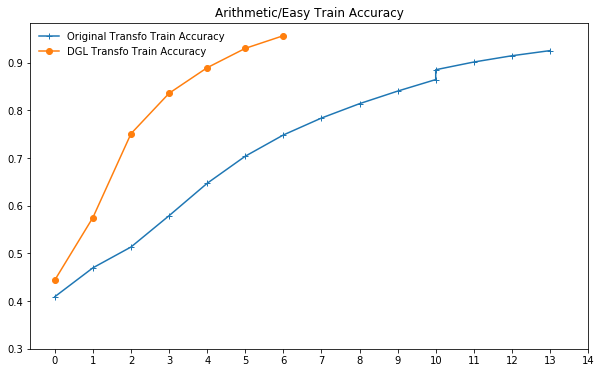

In [47]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()

original_transfo_train_step = list(map(lambda l: l.step, original_transfo_train_accuracy_1))
original_transfo_train_step.extend(list(map(lambda l: l.step, original_transfo_train_accuracy_2)))
original_transfo_train_step.extend(list(map(lambda l: l.step, original_transfo_train_accuracy_3)))

original_transfo_train_value = list(map(lambda l: l.value, original_transfo_train_accuracy_1))
original_transfo_train_value.extend(list(map(lambda l: l.value, original_transfo_train_accuracy_2)))
original_transfo_train_value.extend(list(map(lambda l: l.value, original_transfo_train_accuracy_3)))

ax.plot(
    original_transfo_train_step,
    original_transfo_train_value,
    marker='+', label='Original Transfo Train Accuracy'
)
ax.plot(
    list(map(lambda l: l.step, dgl_transfo_train_accuracy)),
    list(map(lambda l: l.value, dgl_transfo_train_accuracy)),
    marker='o', label='DGL Transfo Train Accuracy'
)
plt.title('Arithmetic/Easy Train Accuracy')
ax.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 15, step=1.0))
plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()

> **As we can see here, while training is much slower per epoch, DGL Transformer accuracy rises much faster and a bit higher than original Transformer (97% vs 94%)**.

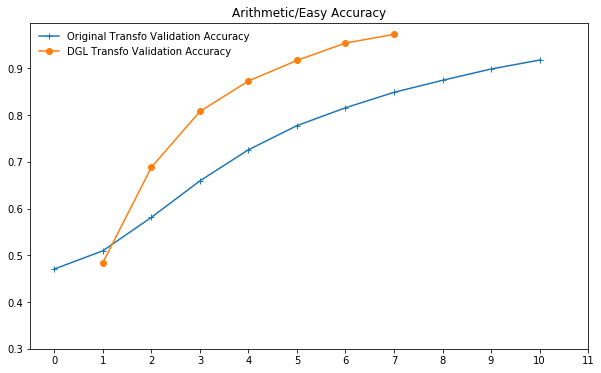

In [32]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()

ax.plot(
    list(map(lambda l: l.step, original_transfo_valid_accuracy)),
    list(map(lambda l: l.value, original_transfo_valid_accuracy)),
    marker='+', label='Original Transfo Validation Accuracy'
)
ax.plot(
    list(map(lambda l: l.step, dgl_transfo_valid_accuracy)),
    list(map(lambda l: l.value, dgl_transfo_valid_accuracy)),
    marker='o', label='DGL Transfo Validation Accuracy'
)
plt.title('Arithmetic/Easy Accuracy')
ax.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 12, step=1.0))
plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()

> **For validation dataset, we see the same faster and higher rise of accuracy with DGL transformer (97% vs 90%). It's interesting to remark that it rises up to the same level of accuracy as train dataset (>95%) while original transformer tends to be a bit lower in validation dataset (<95%)**

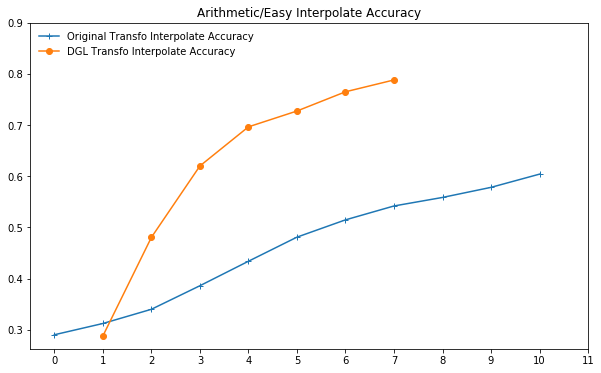

In [35]:
plt.rcParams['figure.figsize'] = [10, 6]

fig, ax = plt.subplots()

ax.plot(
    list(map(lambda l: l.step, original_transfo_interpolate_accuracy)),
    list(map(lambda l: l.value, original_transfo_interpolate_accuracy)),
    marker='+', label='Original Transfo Interpolate Accuracy'
)
ax.plot(
    list(map(lambda l: l.step, dgl_transfo_interpolate_accuracy)),
    list(map(lambda l: l.value, dgl_transfo_interpolate_accuracy)),
    marker='o', label='DGL Transfo Interpolate Accuracy'
)
plt.title('Arithmetic/Easy Interpolate Accuracy')
ax.legend(loc='upper left', frameon=False)
plt.xticks(np.arange(0, 12, step=1.0))
plt.yticks(np.arange(0.3, 1.0, step=0.1))
plt.show()

> **For interpolate dataset (containing more generic questions/answers on this arithmetic problem to test generalization capabilities), it's getting more accurate faster and much higher (80% vs 60%). It's quite interesting because we see here that with DGL Transformer, it has learnt to generalise much better  in less epoch.**

## Check Inference

In [175]:
# build default transformer model
model = utils.build_dgl_transformer()
# restore model from checkpoint
_ = checkpoints.restore_best_checkpoint(exp_name, unique_id, "validation", model)
model = model.to(device)

Extracting state from checkpoints/dgl_transformer_arithmetic_add_or_sub_easy_2019-05-03_1000_validation_best.pth
Loading model state_dict from state found in checkpoints/dgl_transformer_arithmetic_add_or_sub_easy_2019-05-03_1000_validation_best.pth


In [202]:
print("What is 1 + 1", dgl_model_process.predict_single("What is 1 + 1", model, device, graph_collate))
print("Yeah it works!")

What is 1 + 1 ['2']
Yeah it works!


In [203]:
print("What is 10 + 10", dgl_model_process.predict_single("What is 10 + 10", model, device, graph_collate))

print("WHATTTT")

What is 10 + 10 ['200']
WHATTTT


> Actually it doesn't work for basic example... I've discovered there are issues with DGL Transformer inference code using Beam Search. I haven't found why it's not working as expected for now, I need to investigate further what's going wrong in inference as training performance metrics works well. Still work to do on that topic...

## Conclusion

I'm not going to make any definite conclusion based on these very superficial experiments based on short trainings. Yet, it's a cool experiment as DGL Transformer, despite slow training, learns very fast and very accurate on these simple arithmetic math problems while apparently being able to generalize quite well on interpolate dataset which contains problems it has never seen. So it's quite encouraging and I want to study more about those Graph Neural Networks.

I'll try to train on hard difficulty the same DGL Transformer to see if it behaves the same.

Moreover, I need to run the original transformer on a longer training (more than 20epochs) to see the maximum of accuracy it can reach in interpolate mode compared to DGL Transformer.

**If anyone can lend me some bigger parallel GPUs, tell me, I'll try to train those models on them to have more accurate results ;)**

Next Steps:

- use Attention maps to introspect learnt knowledge
- search why inference with beam search fails for basic operations whereas training metrics work well

_See you for more experiments and thanks to [DGL library](www.dgl.org) and the creators of Transformer. Not sure I'll solve all my math problems with neural networks soon but I'm having fun and learning a lot myself ;)_